# Лабораторная работа №4 «Метод стрельбы для решения дифференциальных уравнений второго порядка»

## Дашкевич Артём Владимирович

### Скрин постановки задачи:
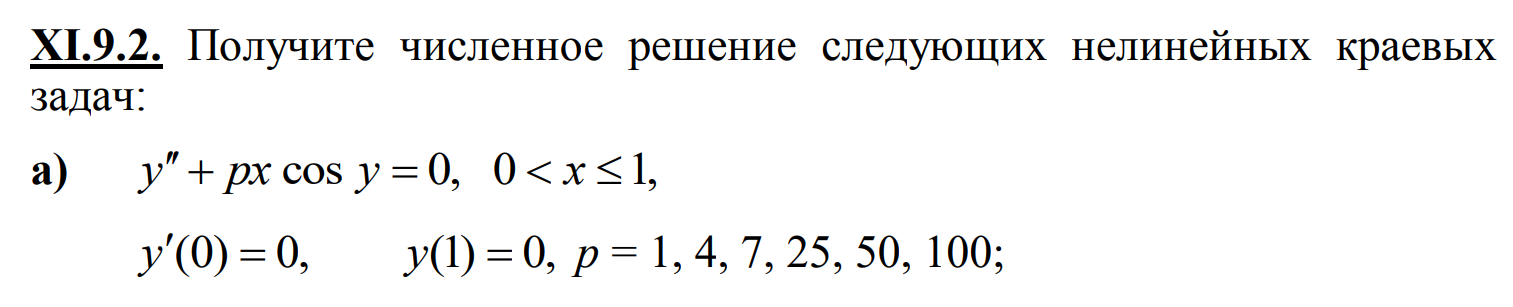

### Описание метода:   
Сделаем замену y' = z и сведём уравнение второго порядка к системе уравнений первого порядка:   
z' = -px * cosy   
y' = z   
При этом краевые условия принимают вид:   
z(0) = 0   
y(1) = 0

Далее используем метод стрельбы для нахождения решения:   
> 1) Возьмём начальные условия для решения системы z(0) = 0, y(0) = A0, где A0 - произвольное число, и решим систему. Пусть в результате решения системы оказалось y(1) = B0, в общем случае не совпадающее с необходимым y(1) = 1.   
> 2) Теперь возьмём другие начальные условия z(0) = 0, y(0) = A1 таким образом, чтобы полученное в результате решения системы y(1) = B1 удовлетворяло следующему условию:   
>>sign(B1 - y_искомое(1)) != sign(B0 - y_искомое(1))
>В данном случае y_искомое(1) = 0 (из условия) и соотношение принимает вид:
>>sign(B1) != sign(B2)   

>В предположении, что решение непрерывно зависит от параметра y(0) получим, что искомое решение находится между A1 и A2:   
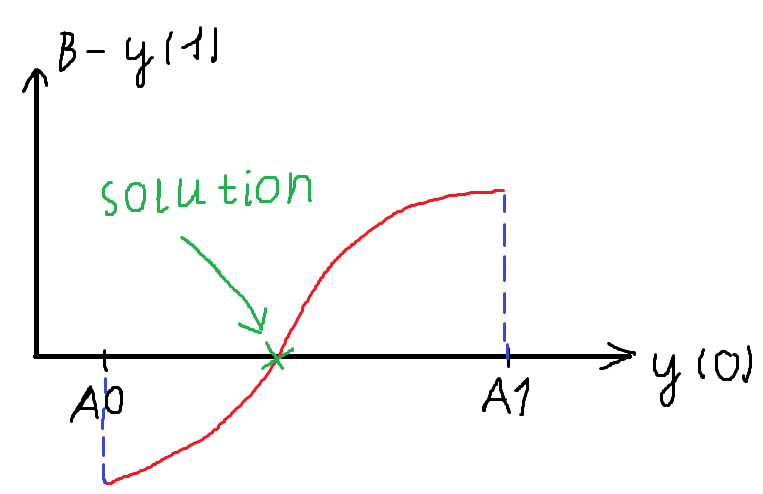

>3) Далее методом дихотомии (бинарного поиска) корректируем границы интервала параметра y(0) до тех пор, пока не достигнем требуемой точности решения на правой границе (B_new <= required_accuracy):   
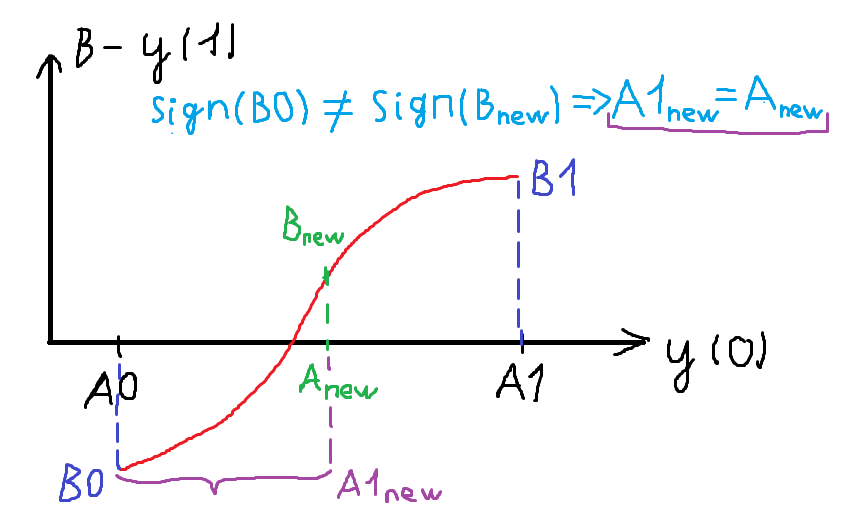

Решение системы с заданными начальными условиями будем производить с помощью неявного метода Рунге-Кутты (использован код с прошлой лабораторной работы):

*#начало кода для решения*

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [153]:
def regulate_size(new_size, y1_0 =0, y2_0 =0):
    time_array = [0] * new_size
    for i in range(new_size):
        time_array[i] = h * i

    y1 = [0] * size
    y1[0] = y1_0

    y2 = [0] * size
    y2[0] = y2_0
    
    return time_array, y1, y2

In [154]:
# Components of function f

def f_1(t, y1, y2):
    return - p * t * math.cos(y2)

def f_2(t, y1, y2):
    return y1

In [155]:
def norm(x, y):
    return math.sqrt(x ** 2 + y ** 2)

def prediction(t, y1, y2, f_1, f_2, h):
    y1_next_it = y1 + h * f_1(t, y1, y2)
    y2_next_it = y2 + h * f_2(t, y1, y2)
    return y1_next_it, y2_next_it

def correction(t, y1, y2, t_next, y1_next_it, y2_next_it, f_1, f_2, h):
    y1_next = y1 + h * (f_1(t, y1, y2) + f_1(t_next, y1_next_it, y2_next_it)) / 2
    y2_next = y2 + h * (f_2(t, y1, y2) + f_2(t_next, y1_next_it, y2_next_it)) / 2
    return y1_next, y2_next

# The "Accuracy" parameter is used to set the breakpoint of the iterative correction pass

def find_next_step(t, y1, y2, t_next, f_1, f_2, h, accuracy):
    y1_next_it, y2_next_it = prediction(t, y1, y2, f_1, f_2, h)
    
    y1_next, y2_next = correction(t, y1, y2, t_next, y1_next_it, y2_next_it, f_1, f_2, h)

    #Stop if the norm of the difference of 2 subsequent iterations turns out to be less than the accuracy
    while norm(y1_next - y1_next_it, y2_next - y2_next_it) > accuracy:
        y1_next_it = y1_next
        y2_next_it = y2_next
        y1_next, y2_next = correction(t, y1, y2, t_next, y1_next_it, y2_next_it, f_1, f_2, h)
    
    return y1_next, y2_next

*#конец кода для решения*

Функция для поиска решения методом дихотомии (бинарного поиска):

In [156]:
def find_solution(x, z, y, z_0, y_target_right_border, accuracy):
    z[0] = z_0  # y'(0)
    
    # A0 = 0, solve system and find B0
    y_left_border_1 = 0
    y_left_border_2 = 0
    y[0] = y_left_border_1
    for i in range(size - 1):
        z[i + 1], y[i + 1] = find_next_step(x[i], z[i], y[i], x[i + 1], f_1, f_2, h, 0.001)
    y_right_border_1 = y[-1]
    
    # Search for A1 satisfying the condition
    y_right_border_2 = y_right_border_1
    j = 1
    while np.sign(y_right_border_1 - y_target_right_border) == np.sign(y_right_border_2 - y_target_right_border):
        y_left_border_2 = j
        y[0] = y_left_border_2
        for i in range(size - 1):
            z[i + 1], y[i + 1] = find_next_step(x[i], z[i], y[i], x[i + 1], f_1, f_2, h, 0.001)
        y_right_border_2 = y[-1]
        j += 1
    
    # initial value in order to enter in the cycle
    new_y_right_border = y_target_right_border + accuracy * 2
    
    # Search by dichotomy method
    while abs(new_y_right_border - y_target_right_border) > accuracy:
        new_y_left_border = (y_left_border_1 + y_left_border_2) / 2
        y[0] = new_y_left_border
        for i in range(size - 1):
            z[i + 1], y[i + 1] = find_next_step(x[i], z[i], y[i], x[i + 1], f_1, f_2, h, 0.001)
        new_y_right_border = y[-1]
        if np.sign(new_y_right_border) != np.sign(y_right_border_1):
            y_left_border_2 = new_y_left_border
        else:
            y_left_border_1 = new_y_left_border

Заполним значения параметра p, точность искомого решения, зададим границы интервала для решения и создадим массивы (z = y'):

In [188]:
p_arr = [1, 4, 7, 25, 50, 100, 200, 500] # more parameter values are used in order to get different pictures on the graph
max_x = 1    # 1 second
accuracy = 0.001

In [189]:
h = 0.0001
size = int(max_x / h + 1)
x, z, y = regulate_size(size)
z_0 = 0

Ищем решение для каждого параметра p из набора:

p =  1


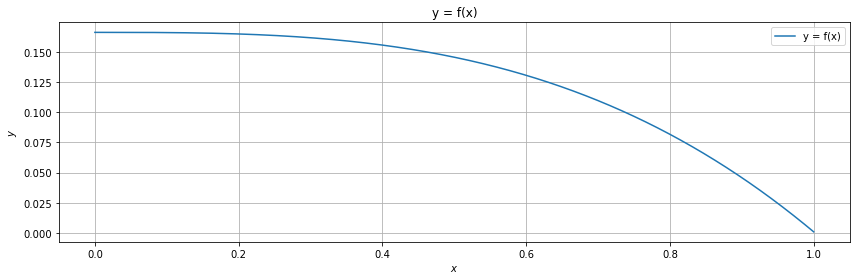

y[1] =  0.0009199667874342723
-----------------------------------------------------------------------------------------------------
p =  4


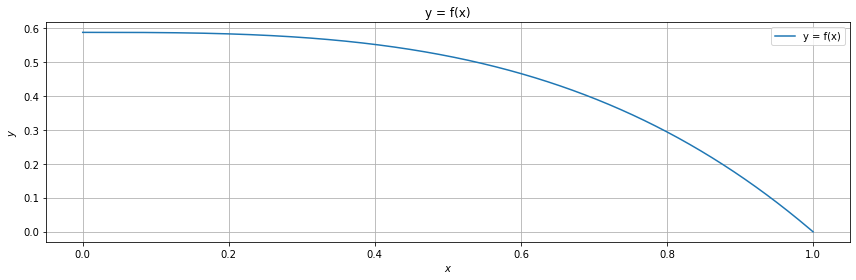

y[1] =  -0.000925264115365438
-----------------------------------------------------------------------------------------------------
p =  7


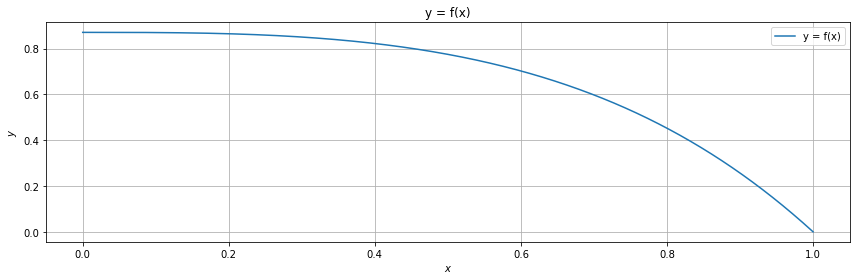

y[1] =  0.0006307702865452792
-----------------------------------------------------------------------------------------------------
p =  25


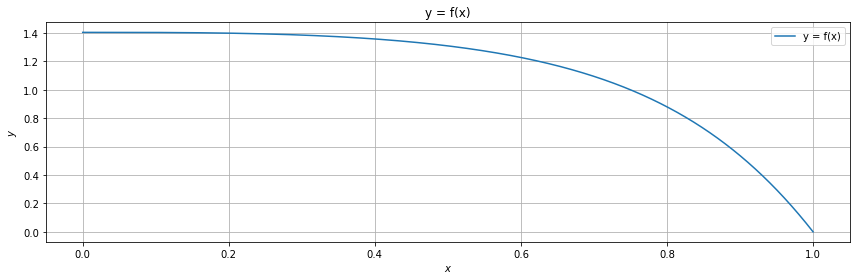

y[1] =  -0.0007490194652986878
-----------------------------------------------------------------------------------------------------
p =  50


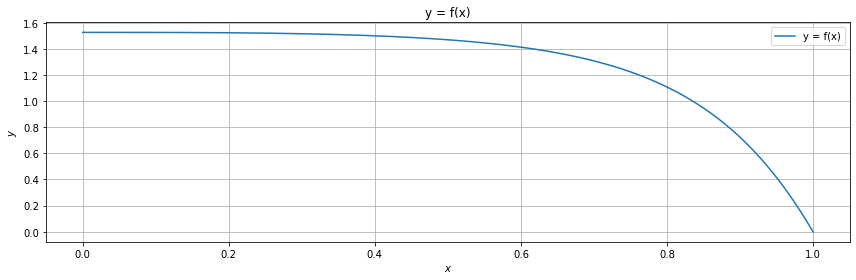

y[1] =  -0.0007866803203721711
-----------------------------------------------------------------------------------------------------
p =  100


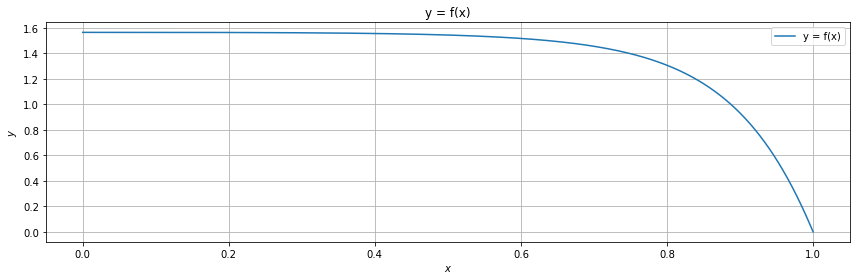

y[1] =  0.0005226776834937172
-----------------------------------------------------------------------------------------------------
p =  200


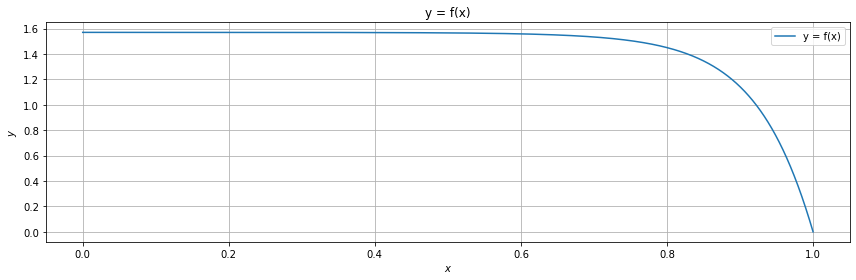

y[1] =  7.482260898149457e-05
-----------------------------------------------------------------------------------------------------
p =  500


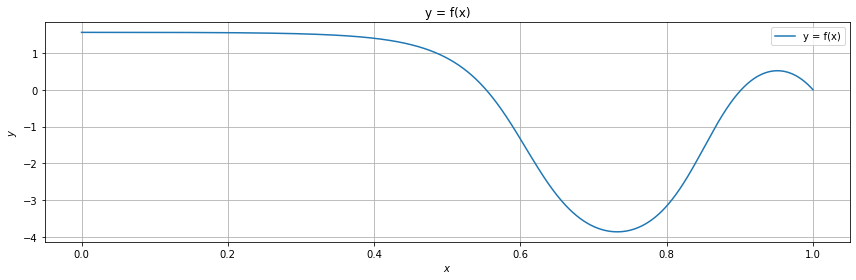

y[1] =  0.0003527538369471816
-----------------------------------------------------------------------------------------------------


In [190]:
for p in p_arr:
    print("p = ", p)

    find_solution(x, z, y, z_0, 0, accuracy)  # y(1) = 0, accuracy = 0.001
    
    # y = f(x)
    plt.figure(figsize=[12, 4])
    plt.plot(x, y, label='y = f(x)')

    plt.title("y = f(x)")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.grid()
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.tight_layout() 
    plt.show()

    print("y[1] = ", y[-1])
    print("-----------------------------------------------------------------------------------------------------")

In [191]:
print("Видно, что каждое решение удовлетворяет условиям:")
print("y'(0) = ", z[0])
print("y(1) = 0 (с учётом точности принадлежит интервалу [", -accuracy, ",", accuracy, "]")

Видно, что каждое решение удовлетворяет условиям:
y'(0) =  0
y(1) = 0 (с учётом точности принадлежит интервалу [ -0.001 , 0.001 ]
